In [1]:
import wandb
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [19]:
import sys, os
if '../' not in sys.path:
    sys.path.append('..')
from source.rank_map import get_rank_map
method = 'admm'
qscheme = 'tensor_affine'
bits = 4
eps = 0.0005
decomp = 'cp3-epc'
seed=42
rank_map = get_rank_map(eps, decomp)
num_samples = 10000
for module in ['layer1', 'layer2', 'layer3', 'layer4']:
    for layer_path in [f'{module}.0.conv1', f'{module}.0.conv2', 
                       f'{module}.1.conv1', f'{module}.1.conv2']:
        rank = rank_map[layer_path]
        factor_name = os.path.join(f"../{bits}bit_{qscheme}",
                                   f"factors_{method}_seed{seed}", 
                                   f"{layer_path}_{method}_random_rank_{rank}_mode_")
        if not os.path.exists(factor_name+'0.pt'):
            print('missing', factor_name)

In [2]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'calibration'
api = wandb.Api()

columns = [
    'qscheme',
    'decomp',
    'eps',
    'calibration_samples',
    'bits',
    'seed',
    'no_layer1',
    'method',
    'acc_calibrated',
    'acc_factorized',
    'macs_reduced'
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
        
        i += 1
        
df.head()

  0%|          | 0/34 [00:00<?, ?it/s]

,qscheme,decomp,eps,calibration_samples,bits,seed,no_layer1,method,acc_calibrated,acc_factorized,macs_reduced
0,tensor_log,cp3-epc,0.0005,4096,8,42,True,admm,0.674536,0.634263,0.566653
1,tensor_affine,cp3-epc,0.0005,4096,8,42,True,admm,0.678637,0.658131,0.566653
2,tensor_log,cp3,0.0001,4096,8,42,True,admm,0.667834,0.558579,0.507955
3,tensor_affine,cp3,0.0001,4096,8,42,True,admm,0.677857,0.590789,0.507955
4,tensor_affine,cp3,0.001,4096,8,42,True,admm,0.662672,0.596591,0.441518


In [45]:
df_sample = df[df.qscheme=='tensor_affine']
df_sample = df_sample[df.eps==0.0001]
df_sample = df_sample[df.calibration_samples==4096]
df_sample = df_sample[df.method=='admm']
df_sample

/tmp/ipykernel_3344291/2676615834.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.eps==0.0001]
/tmp/ipykernel_3344291/2676615834.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.calibration_samples==4096]
/tmp/ipykernel_3344291/2676615834.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.method=='admm']


,qscheme,decomp,eps,calibration_samples,bits,seed,no_layer1,method,acc_calibrated,acc_factorized,macs_reduced
3,tensor_affine,cp3,0.0001,4096,8,42,True,admm,0.677857,0.590789,0.507955
18,tensor_affine,cp3,0.0001,4096,8,42,False,admm,0.675956,0.573624,0.463174


In [34]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'quantization'
api = wandb.Api()

columns = [
    'qscheme',
    'decomp',
    'eps',
    'calibration_samples',
    'bits',
    'seed',
    'param_bw',
    'output_bw',
    'adaround',
    'no_layer1',
    'adaround_iterations',
    'method',
    'bops',
    'macs_reduced',
    'acc_quantized'
]
df = pd.DataFrame([], columns=columns)
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        for col in columns:
            if run.config.get(col) is not None:
                df.loc[i][col] = run.config[col]
            elif run.summary.get(col) is not None:
                df.loc[i][col] = run.summary[col]
            else:
                df.loc[i][col] = None
        
        i += 1
        
df.head()

  0%|          | 0/46 [00:00<?, ?it/s]

,qscheme,decomp,eps,calibration_samples,bits,seed,param_bw,output_bw,adaround,no_layer1,adaround_iterations,method,bops,macs_reduced,acc_quantized
0,tensor_affine,cp3,0.001,4096,8,42,6,8,False,True,None,admm,2.069616,0.441518,0.060699
1,tensor_log,cp3,0.0001,4096,8,42,4,8,False,True,None,admm,1.587359,0.507955,0.00112
2,tensor_affine,cp3,0.0001,4096,8,42,4,8,False,True,None,admm,1.587359,0.507955,0.001
3,tensor_log,cp3,0.0001,4096,8,42,6,8,False,True,None,admm,2.381039,0.507955,0.28247
4,tensor_affine,cp3,0.0001,4096,8,42,6,8,False,True,None,admm,2.381039,0.507955,0.077225


In [40]:
df_sample = df[df.qscheme=='tensor_affine']
df_sample = df_sample[df.eps==0.0001]
df_sample = df_sample[df.calibration_samples==4096]
df_sample = df_sample[df.method=='admm']
df_sample

/tmp/ipykernel_3344291/2676615834.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.eps==0.0001]
/tmp/ipykernel_3344291/2676615834.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.calibration_samples==4096]
/tmp/ipykernel_3344291/2676615834.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sample = df_sample[df.method=='admm']


,qscheme,decomp,eps,calibration_samples,bits,seed,param_bw,output_bw,adaround,no_layer1,adaround_iterations,method,bops,macs_reduced,acc_quantized
2,tensor_affine,cp3,0.0001,4096,8,42,4,8,False,True,None,admm,1.587359,0.507955,0.001
4,tensor_affine,cp3,0.0001,4096,8,42,6,8,False,True,None,admm,2.381039,0.507955,0.077225
11,tensor_affine,cp3,0.0001,4096,8,42,4,8,False,False,None,admm,1.44742,0.463174,0.00114
12,tensor_affine,cp3,0.0001,4096,8,42,6,8,False,False,None,admm,2.17113,0.463174,0.022207


In [38]:
df[df.qscheme=='tensor_affine'][df.eps==0.0001][df.calibration_samples==10000][df.method=='admm']

/tmp/ipykernel_3344291/130543291.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.qscheme=='tensor_affine'][df.eps==0.0001][df.calibration_samples==10000][df.method=='admm']


,qscheme,decomp,eps,calibration_samples,bits,seed,param_bw,output_bw,adaround,no_layer1,adaround_iterations,method,bops,macs_reduced,acc_quantized
14,tensor_affine,cp3,0.0001,10000,8,42,4,8,True,False,None,admm,1.44742,0.463174,0.502541
15,tensor_affine,cp3,0.0001,10000,8,42,6,8,True,False,None,admm,2.17113,0.463174,0.604673
16,tensor_affine,cp3,0.0001,10000,8,42,8,8,True,False,None,admm,2.894841,0.463174,0.619978
18,tensor_affine,cp3,0.0001,10000,8,42,4,8,False,False,None,admm,1.44742,0.463174,0.00102
20,tensor_affine,cp3,0.0001,10000,8,42,6,8,False,False,None,admm,2.17113,0.463174,0.02894
22,tensor_affine,cp3,0.0001,10000,8,42,8,8,False,False,None,admm,2.894841,0.463174,0.56606


In [2]:
# import sys
# if '../' not in sys.path:
#     sys.path.append('..')
# from source.quantization import quantize_tensor
# import torch

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# x = torch.tensor([ -5, -1, 1,2,3,10, 1000])
# bits=8
# quantize_tensor(x, bits, qscheme='tensor_symmetric'), \
# quantize_tensor(x, bits, qscheme='tensor_affine'), \
# quantize_tensor(x, bits, qscheme='tensor_minmaxlog'), \
# quantize_tensor(x, bits, qscheme='tensor_mse'), \
# quantize_tensor(x, bits, qscheme='tensor_log')

In [4]:
# a = torch.arange(-100, 10.)
# a, torch.quantile(a, 0.9)

In [5]:
WANDB_ENTITY = 'darayavaus'
WANDB_PROJECT = 'rank_binary_search'

In [6]:
api = wandb.Api()

In [7]:
df = pd.DataFrame([], columns=['orig_macs', 'redc_macs', 'best_rank', 
                               'lname', 'eps', 'decomposition'])
runs = api.runs('/'.join((WANDB_ENTITY, WANDB_PROJECT)))

i = 0
for run in tqdm(runs):
    if run.state == 'finished':
        df.loc[i] = [None] * len(df.columns)
        
        df.loc[i]['lname'] = run.config['lname']
        df.loc[i]['eps'] = run.config['eps']
        df.loc[i]['decomposition'] = run.config['decomposition']
        
        df.loc[i]['orig_macs'] = run.summary['orig_macs']
        df.loc[i]['redc_macs'] = run.summary['redc_macs']
        df.loc[i]['best_rank'] = run.summary['best_rank']
        
        i += 1
        
df.head()

  0%|          | 0/126 [00:00<?, ?it/s]

,orig_macs,redc_macs,best_rank,lname,eps,decomposition
0,57802752,37616124,247,layer3.0.conv1,0.0005,cp3-epc
1,115605504,44045120,212,layer2.1.conv2,0.0005,cp3-epc
2,115605504,62743520,302,layer2.1.conv1,0.0005,cp3-epc
3,115605504,60873680,293,layer2.0.conv2,0.0005,cp3-epc
4,57802752,76719888,249,layer2.0.conv1,0.0005,cp3-epc


In [9]:
df_slice = df[(df.decomposition=='cp3-epc') & (df.eps==0.0005)].sort_values('lname')
df_slice

,orig_macs,redc_macs,best_rank,lname,eps,decomposition
6,115605504,43392832,101,layer1.0.conv1,0.0005,cp3-epc
8,115605504,38666880,90,layer1.0.conv2,0.0005,cp3-epc
7,115605504,57141056,133,layer1.1.conv1,0.0005,cp3-epc
5,115605504,45970624,107,layer1.1.conv2,0.0005,cp3-epc
4,57802752,76719888,249,layer2.0.conv1,0.0005,cp3-epc
3,115605504,60873680,293,layer2.0.conv2,0.0005,cp3-epc
2,115605504,62743520,302,layer2.1.conv1,0.0005,cp3-epc
1,115605504,44045120,212,layer2.1.conv2,0.0005,cp3-epc
0,57802752,37616124,247,layer3.0.conv1,0.0005,cp3-epc


In [10]:
layer2rank = {record['lname']:record['best_rank'] for record in df_slice[['lname', 'best_rank']].to_dict('records')}
layer2rank

{'layer1.0.conv1': 101,
 'layer1.0.conv2': 90,
 'layer1.1.conv1': 133,
 'layer1.1.conv2': 107,
 'layer2.0.conv1': 249,
 'layer2.0.conv2': 293,
 'layer2.1.conv1': 302,
 'layer2.1.conv2': 212,
 'layer3.0.conv1': 247}

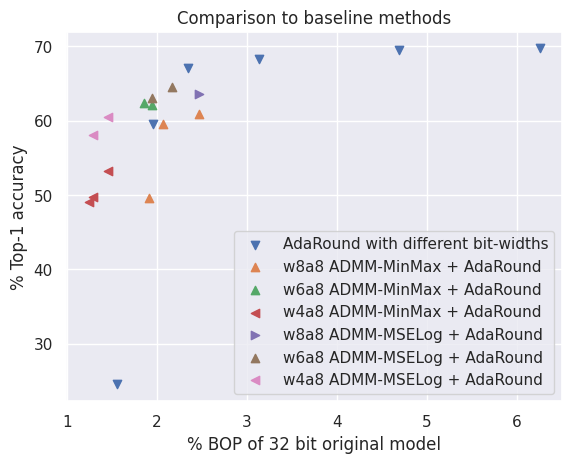

In [6]:
#### plt.axhline(y=69.76, color='skyblue', linestyle = '-', label='original model')
# plt.scatter([1.56, 3.13, 6.25], [5.78, 18.87, 69.76], marker='o', label='Quantization')
plt.scatter([1.56, 1.95, 2.34, 3.13, 4.69, 6.25], [24.535, 59.58, 67.01, 68.28, 69.52, 69.7], marker='v', label='AdaRound with different bit-widths')
# plt.scatter([2.07, 2.47], [55.52, ], marker='s', label='ADMM+Quantization')
plt.scatter([1.91, 2.07, 2.47], [49.64, 59.53, 60.93], marker='^', label='w8a8 ADMM-MinMax + AdaRound')
plt.scatter([1.85, 1.94], [62.4, 62.13], marker='^', label='w6a8 ADMM-MinMax + AdaRound')
plt.scatter([1.24, 1.29, 1.45], [49.11, 49.72, 53.23], marker='<', label='w4a8 ADMM-MinMax + AdaRound')
plt.scatter([2.47], [63.59], marker='>', label='w8a8 ADMM-MSELog + AdaRound')
plt.scatter([1.94, 2.17], [63.07, 64.58], marker='^', label='w6a8 ADMM-MSELog + AdaRound')
plt.scatter([1.29, 1.45], [58.0, 60.46], marker='<', label='w4a8 ADMM-MSELog + AdaRound')

plt.legend()
plt.xlabel('% BOP of 32 bit original model')
plt.ylabel('% Top-1 accuracy')
plt.title('Comparison to baseline methods')

plt.savefig('comparison')
plt.show()

In [85]:
def quantize_tensor_mse(x, bits, qscheme=None, scale=None):
    def _quantize(x_float, maxval, per_channel_axis=0):
        mantissa_bits = torch.tensor(3)
        exponent_bits = 7 - mantissa_bits
        
        if maxval.shape and maxval.shape[0] != 1 and len(maxval.shape) != len(x_float.shape):
            new_shape = [1] * len(x_float.shape)
            new_shape[per_channel_axis] = -1
            maxval = maxval.view(new_shape)
        
        bias = 2 ** exponent_bits - torch.log2(maxval) + torch.log2(2 - 2 ** (-mantissa_bits)) - 1
        print(bias)
        x_clipped = torch.min(torch.max(x_float, -maxval), maxval)

        log_scales = torch.floor(torch.log2(torch.abs(x_clipped)) + bias).detach()
        log_scales = torch.clamp(log_scales, 1.)

        scales = 2. ** (log_scales - mantissa_bits - bias)

        return torch.round(x_clipped / scales) * scales
    
    mx = torch.max(torch.abs(x.min()), torch.abs(x.max()))
    lsp = [torch.linspace(0.1 * mx.item(), 1.2 * mx.item(), 111)]
    # 111 x 1
    linspaces = torch.stack(lsp).to(x.device).transpose(0, 1)
    
    mses = torch.zeros_like(linspaces)
    
    meandims = list(torch.arange(len(x.shape)))
    
    for i, maxval in enumerate(linspaces):
        xfp = _quantize(x, maxval)
        mse = ((x - xfp) ** 2).mean(dim=meandims)
        mses[i, :] = mse
        print(maxval, mse)

    best_mse = mses.argmin(0)
    maxval = torch.tensor([linspaces[best_mse[i], i] for i in range(linspaces.shape[-1])]).to(x.device)

    return _quantize(x, maxval)

In [86]:
quantize_tensor_mse(torch.tensor([-1,2,3,-4,5,6, 1000]), bits=8)

tensor([9.3561])
tensor([100.]) tensor(115714.2891)
tensor([9.2186])
tensor([110.]) tensor(113157.1406)
tensor([9.0931])
tensor([120.]) tensor(110628.5859)
tensor([8.9776])
tensor([130.]) tensor(108128.5703)
tensor([8.8707])
tensor([140.]) tensor(105657.1406)
tensor([8.7712])
tensor([150.]) tensor(103214.3047)
tensor([8.6781])
tensor([160.]) tensor(100800.0078)
tensor([8.5906])
tensor([170.]) tensor(98414.2656)
tensor([8.5081])
tensor([180.]) tensor(96057.1406)
tensor([8.4301])
tensor([190.]) tensor(93728.5781)
tensor([8.3561])
tensor([200.]) tensor(91428.5703)
tensor([8.2858])
tensor([210.]) tensor(89157.1719)
tensor([8.2186])
tensor([220.]) tensor(86914.2891)
tensor([8.1545])
tensor([230.]) tensor(84700.0234)
tensor([8.0931])
tensor([240.]) tensor(82514.2969)
tensor([8.0342])
tensor([250.]) tensor(80357.1484)
tensor([7.9776])
tensor([260.]) tensor(78228.5781)
tensor([7.9232])
tensor([270.]) tensor(76128.5859)
tensor([7.8707])
tensor([280.]) tensor(74057.1406)
tensor([7.8201])
tensor(

tensor([-9.7656e-01,  1.9531e+00,  2.9297e+00, -3.9062e+00,  4.8828e+00,
         5.8594e+00,  1.0000e+03])